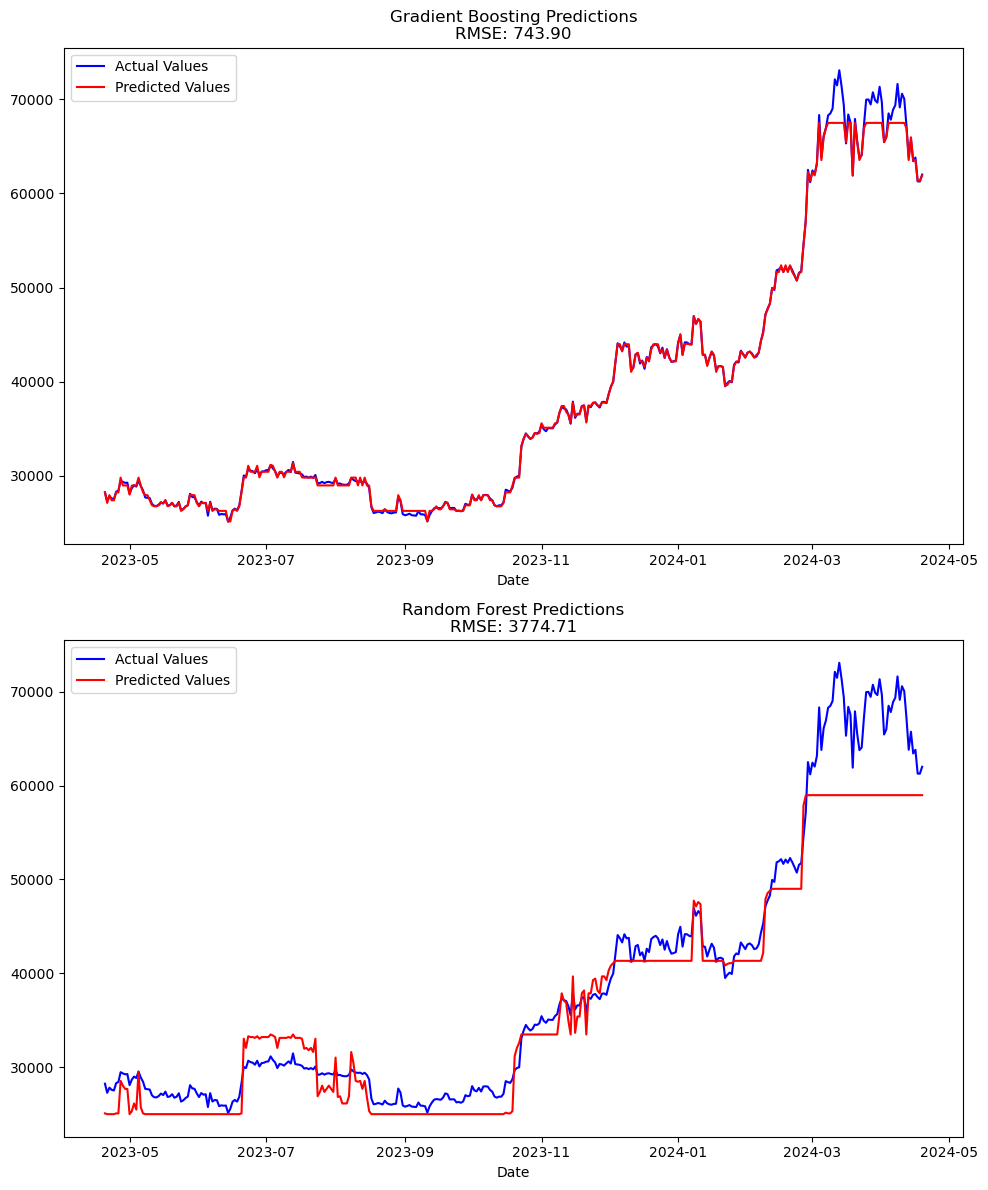

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load the data
file_path = '/Users/rahulvispute/Desktop/SEMESTER/SEM 3/623 final/BTC-USD.csv'
btc_data = pd.read_csv(file_path)

# Preprocessing
# Convert 'Date' column to datetime format
btc_data['Date'] = pd.to_datetime(btc_data['Date'])

# Fill missing values using forward fill method
btc_data.fillna(method='ffill', inplace=True)

# Select the 'Close' price as feature and target (for simplicity, predicting the same day's close)
X = btc_data[['Date', 'Close']]  # Include Date to use later in plotting
y = btc_data['Close']

# Split the data into training and testing sets
# It's important to sort by date if data isn't already sorted to avoid future leakage
btc_data.sort_values('Date', inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Extract date for plotting purposes
train_dates = X_train['Date']
test_dates = X_test['Date']
X_train = X_train.drop(columns=['Date'])
X_test = X_test.drop(columns=['Date'])

# Initialize and train Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the testing set
gb_predictions = gb_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)

# Evaluate the models
gb_rmse = mean_squared_error(y_test, gb_predictions, squared=False)
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)

# Plotting the results
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Gradient Boosting results
axs[0].plot(test_dates, y_test.reset_index(drop=True), label='Actual Values', color='blue')
axs[0].plot(test_dates, gb_predictions, label='Predicted Values', color='red')
axs[0].set_title(f'Gradient Boosting Predictions\nRMSE: {gb_rmse:.2f}')
axs[0].set_xlabel('Date')
axs[0].legend()

# Random Forest results
axs[1].plot(test_dates, y_test.reset_index(drop=True), label='Actual Values', color='blue')
axs[1].plot(test_dates, rf_predictions, label='Predicted Values', color='red')
axs[1].set_title(f'Random Forest Predictions\nRMSE: {rf_rmse:.2f}')
axs[1].set_xlabel('Date')
axs[1].legend()

plt.tight_layout()
plt.show()

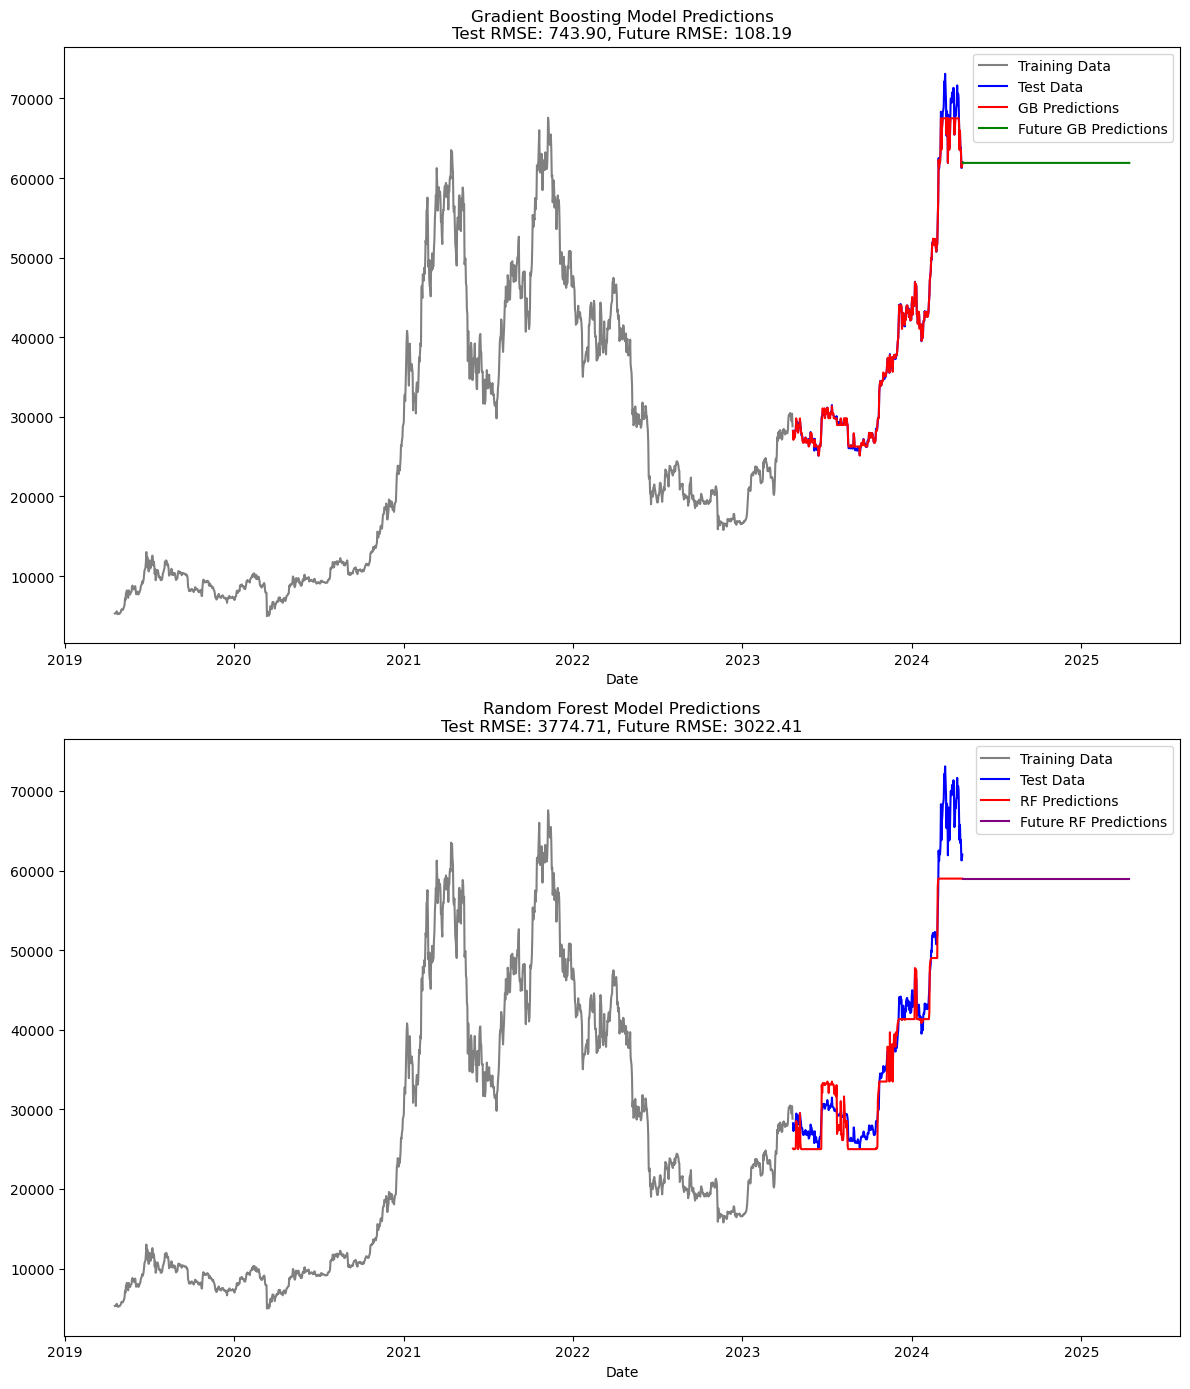

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")  # Suppress warnings

# Load the data
file_path = '/Users/rahulvispute/Desktop/SEMESTER/SEM 3/623 final/BTC-USD.csv'
btc_data = pd.read_csv(file_path)

# Preprocessing
btc_data['Date'] = pd.to_datetime(btc_data['Date'])
btc_data.fillna(method='ffill', inplace=True)
btc_data.sort_values('Date', inplace=True)

# Prepare the features
X = btc_data[['Close']]
y = btc_data['Close']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
train_dates = btc_data.iloc[X_train.index]['Date']
test_dates = btc_data.iloc[X_test.index]['Date']

# Initialize models
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)

# Train the models
gb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Make predictions
gb_predictions = gb_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)

# Compute RMSE for test predictions
gb_rmse_test = mean_squared_error(y_test, gb_predictions, squared=False)
rf_rmse_test = mean_squared_error(y_test, rf_predictions, squared=False)

# Future predictions for 60 days
last_value = X.iloc[-1].values.reshape(1, -1)
future_dates = [btc_data['Date'].iloc[-1] + timedelta(days=x) for x in range(1, 361)]
future_gb_predictions = []
future_rf_predictions = []

for i in range(360):
    next_gb_value = gb_model.predict(last_value)
    next_rf_value = rf_model.predict(last_value)
    future_gb_predictions.append(next_gb_value[0])
    future_rf_predictions.append(next_rf_value[0])
    last_value = next_gb_value.reshape(1, -1)

# Compute RMSE for future predictions (using the last actual value as truth)
gb_rmse_future = np.sqrt(np.mean((np.array(future_gb_predictions) - y.iloc[-1]) ** 2))
rf_rmse_future = np.sqrt(np.mean((np.array(future_rf_predictions) - y.iloc[-1]) ** 2))

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(12, 14))

# Plot existing predictions
axs[0].plot(train_dates, y_train, label='Training Data', color='gray')
axs[0].plot(test_dates, y_test, label='Test Data', color='blue')
axs[0].plot(test_dates, gb_predictions, label='GB Predictions', color='red')
axs[0].plot(future_dates, future_gb_predictions, label='Future GB Predictions', color='green')
axs[0].set_title(f'Gradient Boosting Model Predictions\nTest RMSE: {gb_rmse_test:.2f}, Future RMSE: {gb_rmse_future:.2f}')
axs[0].set_xlabel('Date')
axs[0].legend()

axs[1].plot(train_dates, y_train, label='Training Data', color='gray')
axs[1].plot(test_dates, y_test, label='Test Data', color='blue')
axs[1].plot(test_dates, rf_predictions, label='RF Predictions', color='red')
axs[1].plot(future_dates, future_rf_predictions, label='Future RF Predictions', color='purple')
axs[1].set_title(f'Random Forest Model Predictions\nTest RMSE: {rf_rmse_test:.2f}, Future RMSE: {rf_rmse_future:.2f}')
axs[1].set_xlabel('Date')
axs[1].legend()

plt.tight_layout()
plt.show()


In [5]:
# Future predictions for 30 days
last_value = X.iloc[-1].values.reshape(1, -1)
future_dates_30 = [btc_data['Date'].iloc[-1] + timedelta(days=x) for x in range(1, 31)]
future_gb_predictions_30 = []
future_rf_predictions_30 = []

for i in range(30):
    next_gb_value_30 = gb_model.predict(last_value)
    next_rf_value_30 = rf_model.predict(last_value)
    future_gb_predictions_30.append(next_gb_value_30[0])
    future_rf_predictions_30.append(next_rf_value_30[0])
    last_value = next_gb_value_30.reshape(1, -1)

# Print the predictions for the next 30 days
print("Gradient Boosting Predictions for the next 30 days:")
for date, pred in zip(future_dates_30, future_gb_predictions_30):
    print(f"{date.date()}: {pred:.2f}")

print("\nRandom Forest Predictions for the next 30 days:")
for date, pred in zip(future_dates_30, future_rf_predictions_30):
    print(f"{date.date()}: {pred:.2f}")


Gradient Boosting Predictions for the next 30 days:
2024-04-20: 61922.83
2024-04-21: 61897.48
2024-04-22: 61897.48
2024-04-23: 61897.48
2024-04-24: 61897.48
2024-04-25: 61897.48
2024-04-26: 61897.48
2024-04-27: 61897.48
2024-04-28: 61897.48
2024-04-29: 61897.48
2024-04-30: 61897.48
2024-05-01: 61897.48
2024-05-02: 61897.48
2024-05-03: 61897.48
2024-05-04: 61897.48
2024-05-05: 61897.48
2024-05-06: 61897.48
2024-05-07: 61897.48
2024-05-08: 61897.48
2024-05-09: 61897.48
2024-05-10: 61897.48
2024-05-11: 61897.48
2024-05-12: 61897.48
2024-05-13: 61897.48
2024-05-14: 61897.48
2024-05-15: 61897.48
2024-05-16: 61897.48
2024-05-17: 61897.48
2024-05-18: 61897.48
2024-05-19: 61897.48

Random Forest Predictions for the next 30 days:
2024-04-20: 58983.32
2024-04-21: 58983.32
2024-04-22: 58983.32
2024-04-23: 58983.32
2024-04-24: 58983.32
2024-04-25: 58983.32
2024-04-26: 58983.32
2024-04-27: 58983.32
2024-04-28: 58983.32
2024-04-29: 58983.32
2024-04-30: 58983.32
2024-05-01: 58983.32
2024-05-02: 58983